Updated: 17/01/24

We compare start times determined by (regular) mismatch and spatial mismatch ('kicking in' of mode). 

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import qnmfitsrd as qnmfits
from multiprocessing import Pool
from spatial_reconstruction import *
from matplotlib.animation import FuncAnimation
from scipy.interpolate import UnivariateSpline
from tqdm import tqdm

l_max = 4
n_max = 4

sim = qnmfits.SXS(ID=305, zero_time=(2,2))

Found the following files to load from the SXS catalog:
    SXS:BBH:0305v5/Lev6/metadata.json
Found the following files to load from the SXS catalog:
    SXS:BBH:0305v5/Lev6/rhOverM_Asymptotic_GeometricUnits_CoM.h5


In [8]:
mapping = [(3,3,0,1)]

QNMs = [(lam,mu,n,p) for lam in np.arange(2, l_max+1)
                        for mu in np.arange(-lam, lam+1)
                           for n in np.arange(0, n_max+1)
                              for p in (-1, +1)]

100%|██████████| 200/200 [02:21<00:00,  1.41it/s]


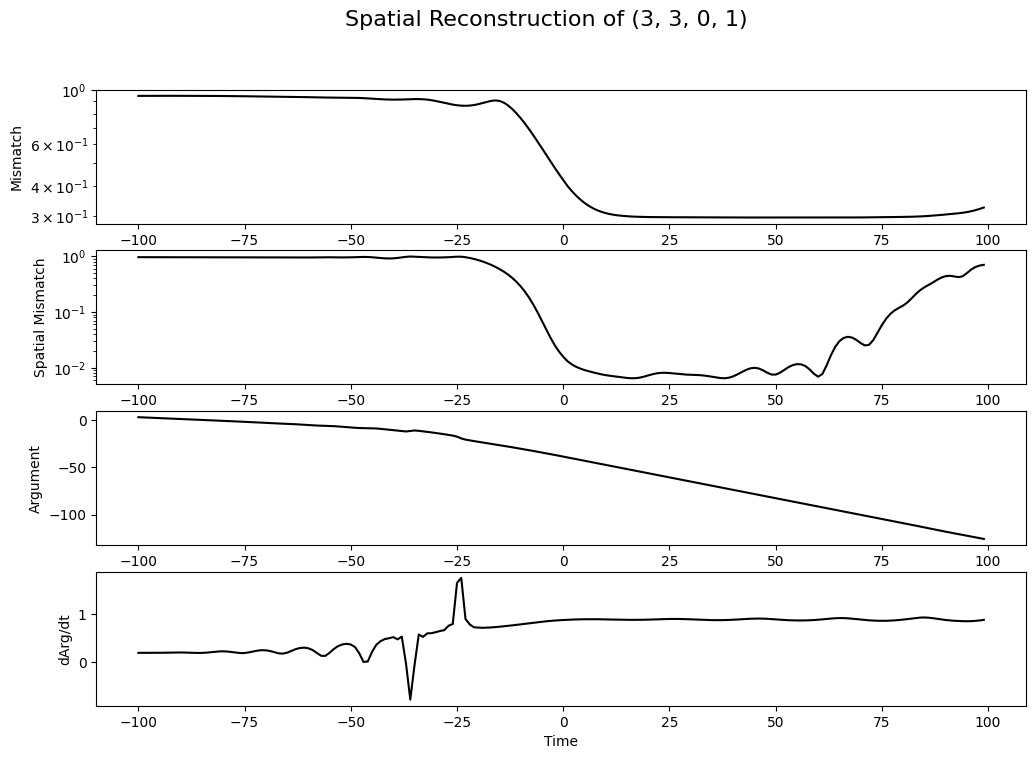

In [9]:
tstart = -100
tend = 100
tstep = 1

lon = np.linspace(-np.pi, np.pi, 200)
lat = np.linspace(-np.pi/2, np.pi/2, 200)
Lon, Lat = np.meshgrid(lon, lat)

mm_list = [] 
sm_list = []
arg_list = []
times_list = np.arange(tstart, tend, tstep)

map = mapping[0]

G = spheroidal(np.pi/2-Lat, Lon, map, l_max, sim.chif_mag)

for step in tqdm(times_list):
    best_fit = qnmfits.mapping_multimode_ringdown_fit(sim.times, 
                                                sim.h, 
                                                modes=QNMs,
                                                Mf=sim.Mf,
                                                chif=sim.chif_mag,
                                                t0=step,
                                                mapping_modes=mapping,
                                                spherical_modes=[(l,m) for l in np.arange(2, l_max+1)
                                                                for m in np.arange(-l,l+1)])

    F = mode_mapping(np.pi/2-Lat, Lon, best_fit, map, l_max)
    sm, arg, _ = spatial_mismatch(F, G, num_points=100)
    sm_list.append(sm)
    arg_list.append(arg)

    best_fit_r = qnmfits.multimode_ringdown_fit(sim.times, 
                                            sim.h, 
                                            modes=[(2,2,0,1)],
                                            Mf=sim.Mf,
                                            chif=sim.chif_mag,
                                            t0=step,
                                            spherical_modes=[(l,m) for l in np.arange(2, l_max+1)
                                                            for m in np.arange(-l,l+1)])
    
    mm_list.append(best_fit_r['mismatch'])

fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(12,8))

fig.suptitle(f'Mismatches of {map} over time', fontsize=16)

axs[0].plot(times_list, mm_list, color='black')
axs[0].set_yscale('log')
axs[0].set_ylabel('Mismatch')

axs[1].plot(times_list, sm_list, color='black')
axs[1].set_yscale('log')
axs[1].set_ylabel('Spatial Mismatch')

plt.xlabel('Time')
plt.show()
